In [1]:
!pip install category_encoders
!pip install langdetect


# Feature Engineering

## Introduction

This notebook provides an in-depth exploration of feature engineering applied to the dataset. The dataset comprises job postings with various categorical features that predict if a job post is real or fake. The primary objectives of this feature engineering task are:
- **[Handling Missing Values](#handling-missing-values)**: Find ways to handle missing data in the different features.
- [**Encode Categorical Variables**](#encoding): Transform categorical features into numeric values.
- [**Reducing Cardinality**](#reduce_cardinality): Simplify features with high cardinality.
- [**Create New Features**](#new_features): Derive additional features from existing data to enhance model performance.
- [**Data Visualizations**](#visualizations): Data Visualizations.



## Importing required libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import re
from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
postings_df = pd.read_csv('/Users/joycendichu/data_machine_learning/real-or-fake-fake-jobposting-prediction.csv')

In [6]:
postings_df.head(10)

,row_idx,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
7,7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8,8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0
9,9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0


In [7]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [8]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17534
 True       346
 Name: count, dtype: int64,
 department
 True     11547
 False     6333
 Name: count, dtype: int64,
 salary_range
 True     15012
 False     2868
 Name: count, dtype: int64,
 company_profile
 False    14572
 True      3308
 Name: count, dtype: int64,
 description
 False    17879
 True         1
 Name: count, dtype: int64,
 requirements
 False    15184
 True      2696
 Name: count, dtype: int64,
 benefits
 False    10668
 True      7212
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    14409
 True      3471
 Name: count, dtype: int64,
 required_experience
 False    10830
 True      7050
 Name: count, dtype: int

In [9]:
postings_df['title'].duplicated().value_counts()

title
False    11231
True      6649
Name: count, dtype: int64

In [10]:
job_to_info = {}

for index, row in postings_df.iterrows():
    if row['title'] not in job_to_info:
        job_to_info[row['title']] = {}
    if pd.notna(row.get('department')):
        job_to_info[row['title']]['department'] = row['department']
    if pd.notna(row.get('requirements')):
        job_to_info[row['title']]['requirements'] = row['requirements']
    if pd.notna(row.get('benefits')):
        job_to_info[row['title']]['benefits'] = row['benefits']
    if pd.notna(row.get('function')):
        job_to_info[row['title']]['function'] = row['function']
    if pd.notna(row.get('industry')):
        job_to_info[row['title']]['industry'] = row['industry']

def fill_missing_values(row, column):
    if pd.isnull(row[column]):
        return job_to_info.get(row['title'], {}).get(column, row[column])
    return row[column]

columns_to_fill = ['department', 'requirements', 'benefits', 'function', 'industry']

for column in columns_to_fill:
    if column in postings_df.columns:
        postings_df[column] = postings_df.apply(lambda row: fill_missing_values(row, column), axis=1)
    else:
        print(f"Warning: Column '{column}' not found in DataFrame.")

print(postings_df)

       row_idx  job_id                                              title  \
0            0       1                                   Marketing Intern   
1            1       2          Customer Service - Cloud Video Production   
2            2       3            Commissioning Machinery Assistant (CMA)   
3            3       4                  Account Executive - Washington DC   
4            4       5                                Bill Review Manager   
...        ...     ...                                                ...   
17875    17875   17876                   Account Director - Distribution    
17876    17876   17877                                 Payroll Accountant   
17877    17877   17878  Project Cost Control Staff Engineer - Cost Con...   
17878    17878   17879                                   Graphic Designer   
17879    17879   17880                         Web Application Developers   

                   location   department salary_range  \
0          US, NY,

In [11]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [12]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17534
 True       346
 Name: count, dtype: int64,
 department
 True     9199
 False    8681
 Name: count, dtype: int64,
 salary_range
 True     15012
 False     2868
 Name: count, dtype: int64,
 company_profile
 False    14572
 True      3308
 Name: count, dtype: int64,
 description
 False    17879
 True         1
 Name: count, dtype: int64,
 requirements
 False    15886
 True      1994
 Name: count, dtype: int64,
 benefits
 False    12331
 True      5549
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    14409
 True      3471
 Name: count, dtype: int64,
 required_experience
 False    10830
 True      7050
 Name: count, dtype: int64

In [13]:
most_frequent_value = postings_df['employment_type'].mode()[0]
print(most_frequent_value)
postings_df['employment_type']= postings_df['employment_type'].fillna(most_frequent_value)

Full-time


In [14]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [15]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17534
 True       346
 Name: count, dtype: int64,
 department
 True     9199
 False    8681
 Name: count, dtype: int64,
 salary_range
 True     15012
 False     2868
 Name: count, dtype: int64,
 company_profile
 False    14572
 True      3308
 Name: count, dtype: int64,
 description
 False    17879
 True         1
 Name: count, dtype: int64,
 requirements
 False    15886
 True      1994
 Name: count, dtype: int64,
 benefits
 False    12331
 True      5549
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    17880
 Name: count, dtype: int64,
 required_experience
 False    10830
 True      7050
 Name: count, dtype: int64,
 required_educ

In [16]:
most_frequent_by_group = postings_df.groupby('employment_type')[['industry', 'requirements']].transform(lambda x: x.mode()[0])

postings_df['industry'] = postings_df['industry'].fillna(most_frequent_by_group['industry'])
postings_df['requirements'] = postings_df['requirements'].fillna(most_frequent_by_group['requirements'])

In [17]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [18]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17534
 True       346
 Name: count, dtype: int64,
 department
 True     9199
 False    8681
 Name: count, dtype: int64,
 salary_range
 True     15012
 False     2868
 Name: count, dtype: int64,
 company_profile
 False    14572
 True      3308
 Name: count, dtype: int64,
 description
 False    17879
 True         1
 Name: count, dtype: int64,
 requirements
 False    17880
 Name: count, dtype: int64,
 benefits
 False    12331
 True      5549
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    17880
 Name: count, dtype: int64,
 required_experience
 False    10830
 True      7050
 Name: count, dtype: int64,
 required_education
 False    

In [19]:
postings_df['required_experience'] = postings_df['required_experience'].fillna(postings_df['required_experience'].mode()[0])

In [20]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [21]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17534
 True       346
 Name: count, dtype: int64,
 department
 True     9199
 False    8681
 Name: count, dtype: int64,
 salary_range
 True     15012
 False     2868
 Name: count, dtype: int64,
 company_profile
 False    14572
 True      3308
 Name: count, dtype: int64,
 description
 False    17879
 True         1
 Name: count, dtype: int64,
 requirements
 False    17880
 Name: count, dtype: int64,
 benefits
 False    12331
 True      5549
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    17880
 Name: count, dtype: int64,
 required_experience
 False    17880
 Name: count, dtype: int64,
 required_education
 False    9775
 True     8

In [22]:
postings_df['location'] = postings_df['location'].apply(lambda x: random.choice(postings_df['location'].dropna().unique()) if pd.isna(x) else x)

In [23]:
def fill_most_frequent(group):
    return group.transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

columns_to_fill = ['department', 'description', 'benefits', 'function']
for column in columns_to_fill:
    postings_df[column] = postings_df.groupby('employment_type')[column].apply(fill_most_frequent).reset_index(level=0, drop=True)


In [24]:
postings_df = postings_df.drop(columns=['required_education','company_profile','salary_range'])

In [25]:
null_columns = [postings_df[column].isnull().value_counts() for column in postings_df.columns ]

In [26]:
null_columns

[row_idx
 False    17880
 Name: count, dtype: int64,
 job_id
 False    17880
 Name: count, dtype: int64,
 title
 False    17880
 Name: count, dtype: int64,
 location
 False    17880
 Name: count, dtype: int64,
 department
 False    17880
 Name: count, dtype: int64,
 description
 False    17880
 Name: count, dtype: int64,
 requirements
 False    17880
 Name: count, dtype: int64,
 benefits
 False    17880
 Name: count, dtype: int64,
 telecommuting
 False    17880
 Name: count, dtype: int64,
 has_company_logo
 False    17880
 Name: count, dtype: int64,
 has_questions
 False    17880
 Name: count, dtype: int64,
 employment_type
 False    17880
 Name: count, dtype: int64,
 required_experience
 False    17880
 Name: count, dtype: int64,
 industry
 False    17880
 Name: count, dtype: int64,
 function
 False    17880
 Name: count, dtype: int64,
 fraudulent
 False    17880
 Name: count, dtype: int64]

In [27]:
description = postings_df['description']

In [28]:
description

0        Food52, a fast-growing, James Beard Award-winn...
1        Organised - Focused - Vibrant - Awesome!Do you...
2        Our client, located in Houston, is actively se...
3        THE COMPANY: ESRI – Environmental Systems Rese...
4        JOB TITLE: Itemization Review ManagerLOCATION:...
                               ...                        
17875    Just in case this is the first time you’ve vis...
17876    The Payroll Accountant will focus primarily on...
17877    Experienced Project Cost Control Staff Enginee...
17878    Nemsia Studios is looking for an experienced v...
17879    Who are we?Vend is an award winning web based ...
Name: description, Length: 17880, dtype: object

## <a name="handling-missing-values"></a>1. Handling Missing Values

### Overview
Missing values can skew analysis and predictions. We’ll start by calculating both the sum and percentage of missing values per feature to understand their extent and impact

In [30]:
posting_df = pd.read_csv('/Users/joycendichu/data_machine_learning/real-or-fake-fake-jobposting-prediction.csv')

In [31]:
posting_df.isna().sum()

row_idx                    0
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [32]:
#get the missing percentaages of each column
missing_percentages = posting_df.isna().mean() * 100
print(missing_percentages)

row_idx                 0.000000
job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


From the above output, we can identify features with high, medium, and low percentages of missing values. This classification will guide us in choosing the most appropriate method for handling the missing data.

### 1.Imputation Using Mode

For the columns `'location'`, `'description'`, and `'employment_type'`, mode imputation was used. These columns had a low percentage of missing values, making mode imputation an appropriate choice. 

**Mode imputation** involves replacing missing values with the most frequent value (mode) of the column. This method is suitable as it preserves the most common data points and is straightforward to implement.

#### Code


In [35]:
def mode_imputation(posting_df, columns):
    for column in columns:
        mode_val = posting_df[column].mode()[0]  
        print(mode_val)
        posting_df[column] = posting_df[column].fillna(mode_val)
    return posting_df

In [36]:
posting_df.head(7)

,row_idx,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
6,6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0


### 2.Handling Salary Range

The `salary_range` feature was initially in a range format (e.g., "50000-70000").This column was split into two separate features: `min_salary` and `max_salary`. 

**Process:**
1. **Split the Salary Range**: The `salary_range` values were divided into `min_salary` and `max_salary` based on the hyphen ("-") separator.
2. **Convert to Numeric Values**: The new columns were converted to numeric values to facilitate numerical analysis.
3. **Handle Missing Values**: Missing or improperly formatted values were filled with `0`.


In [38]:
def parse_salary_range(salary_str):
    try:
        min_salary, max_salary = salary_str.split('-')
        return float(min_salary), float(max_salary)
    except:
        return pd.NA, pd.NA

posting_df[['min_salary', 'max_salary']] = posting_df['salary_range'].apply(parse_salary_range).apply(pd.Series)

# Convert columns to numeric
posting_df['min_salary'] = pd.to_numeric(posting_df['min_salary'])
posting_df['max_salary'] = pd.to_numeric(posting_df['max_salary'])

posting_df['min_salary'] = posting_df['min_salary'].fillna(0)
posting_df['max_salary'] = posting_df['max_salary'].fillna(0)


In [39]:
posting_df.head(10)

,row_idx,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,...,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,...,1,0,Other,Internship,NaN,NaN,Marketing,0,0.0,0.0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,...,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0.0,0.0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,...,1,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,...,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0.0,0.0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,...,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0,0.0
5,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
6,6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,...,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,20000.0,28000.0
7,7,8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,...,1,1,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
8,8,9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,...,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0,0.0,0.0
9,9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,...,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,0.0,0.0


### 3.Creating Missing Value Indicators

To address features with a higher percentage of missing values, new columns were created to specifically indicate the presence of missing data. This approach was applied to the `department`, `min_salary`, and `max_salary` columns. 

**Process:**
1. **Identify Missing Values**: For each specified column, a new binary column was created to indicate whether a value is missing (`True` if missing, `False` otherwise).
2. **Implementation**: The new columns were named by appending `_missing` to the original column names.


In [41]:
def create_new_columns(posting_df,columns):
    for column in columns:
        posting_df[column + '_missing'] = posting_df[column].isna()
create_new_columns(posting_df, ['department','min_salary','max_salary'])   


In [42]:
posting_df.head(7)

,row_idx,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,...,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary,department_missing,min_salary_missing,max_salary_missing
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,...,Internship,NaN,NaN,Marketing,0,0.0,0.0,False,False,False
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,0.0,0.0,False,False,False
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.0,True,False,False
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0.0,0.0,False,False,False
4,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,...,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0,0.0,True,False,False
5,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0.0,0.0,True,False,False
6,6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,...,Mid-Senior level,Master's Degree,Online Media,Management,0,20000.0,28000.0,False,False,False


In [43]:
missing_percentages = posting_df.isna().mean() * 100

In [44]:
missing_percentages

row_idx                 0.000000
job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
min_salary              0.000000
max_salary              0.000000
department_missing      0.000000
min_salary_missing      0.000000
max_salary_missing      0.000000
dtype: float64

### 4.Handling Missing Values in required_experience

In this section, we addressed missing values in the `required_experience` column by replacing any incorrect string representations of missing values and imputing the remaining missing values.

**Process:**
1. **Replace 'nan' Strings**: Replaced any occurrences of the string `'nan'` with `pd.NA` to ensure that these are recognized as missing values.
2. **Impute Missing Values**: Used mode imputation to fill in the missing values. The mode (most frequent value) was used to replace `pd.NA` values in the column.


In [46]:
posting_df['required_experience'].replace('nan', pd.NA)

def impute_missing(posting_df, column):
    mode_val = posting_df[column].mode()[0]
    print(mode_val)
    posting_df[column] = posting_df[column].fillna(mode_val)

impute_missing(posting_df, 'required_experience')

Mid-Senior level


### 5.Group-Based Mode Imputation

In this section, we handle missing values by filling them with the most frequent values within specified groups. This method groups the data based on a specified column and imputes missing values using the mode within each group.

**Process:**
1. **Create Function for Imputation**: A function, `fill_missing_by_mode`, was created to fill missing values based on the most frequent value within each group.
2. **Apply Function**: Applied this function to impute missing values in the specified columns by grouping the data based on the `employment_type` column.


In [48]:
def fill_missing_by_mode(posting_df, group_col, fill_cols):
    most_frequent_by_group = posting_df.groupby(group_col)[fill_cols].transform(lambda x: x.mode()[0] if not x.mode().empty else pd.NA)
    
    for col in fill_cols:
        posting_df[col] = posting_df[col].fillna(most_frequent_by_group[col])
    
    return posting_df

posting_df = fill_missing_by_mode(posting_df, 'employment_type', ['industry', 'requirements', 'company_profile','function'])


In [49]:
posting_df = posting_df.drop(columns=['required_education','benefits','department','salary_range','min_salary','max_salary'])

In [50]:
missing_percentages = posting_df.isna().mean() * 100

In [51]:
missing_percentages

row_idx                 0.000000
job_id                  0.000000
title                   0.000000
location                1.935123
company_profile         5.313199
description             0.005593
requirements            5.385906
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience     0.000000
industry               17.785235
function               16.778523
fraudulent              0.000000
department_missing      0.000000
min_salary_missing      0.000000
max_salary_missing      0.000000
dtype: float64

In [52]:
posting_df.head(10)

,row_idx,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent,department_missing,min_salary_missing,max_salary_missing
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,Internship,E-Learning,Marketing,0,False,False,False
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0,False,False,False
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,Mid-Senior level,NaN,NaN,0,True,False,False
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0,False,False,False
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0,True,False,False
5,5,6,Accounting Clerk,"US, MD,",NaN,Job OverviewApex is an environmental consultin...,NaN,0,0,0,NaN,Mid-Senior level,NaN,NaN,0,True,False,False
6,6,7,Head of Content (m/f),"DE, BE, Berlin","Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,0,1,1,Full-time,Mid-Senior level,Online Media,Management,0,False,False,False
7,7,8,Lead Guest Service Specialist,"US, CA, San Francisco",Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",0,1,1,NaN,Mid-Senior level,NaN,NaN,0,True,False,False
8,8,9,HP BSM SME,"US, FL, Pensacola",Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,0,1,1,Full-time,Associate,Information Technology and Services,Information Technology,0,True,False,False
9,9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix","Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,0,1,0,Part-time,Entry level,Financial Services,Customer Service,0,True,False,False


In [53]:
posting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   row_idx              17880 non-null  int64 
 1   job_id               17880 non-null  int64 
 2   title                17880 non-null  object
 3   location             17534 non-null  object
 4   company_profile      16930 non-null  object
 5   description          17879 non-null  object
 6   requirements         16917 non-null  object
 7   telecommuting        17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      14409 non-null  object
 11  required_experience  17880 non-null  object
 12  industry             14700 non-null  object
 13  function             14880 non-null  object
 14  fraudulent           17880 non-null  int64 
 15  department_missing   17880 non-null  bool  
 16  min_

## <a name="encoding"></a>2. Encode Categorical Variables


Encoding categorical variables is crucial for converting non-numeric data into a format that machine learning algorithms can understand. In this section, we will explore various encoding techniques to transform categorical features into numeric values.

My dataset had a mixture of ordinal and nominal categories

In [55]:
posting_df['required_experience'].unique()

array(['Internship', 'Not Applicable', 'Mid-Senior level', 'Associate',
       'Entry level', 'Executive', 'Director'], dtype=object)

### 1.Ordinal Encoding

**Ordinal Encoding** is used for categorical features where the categories have a meaningful order or rank. This method assigns a unique integer to each category, reflecting its ordinal position.

In this case, I applied Ordinal Encoding to the `required_experience` column because the categories represent levels of experience with a clear progression from lower to higher levels("Internship" to "Director").


In [57]:
experience_mapping = {
    'Not Applicable': 0,
    'Internship': 1,
    'Entry level': 2,
    'Associate': 3,
    'Mid-Senior level': 4,
    'Executive': 5,
    'Director': 6
}
posting_df['required_experience'] = posting_df['required_experience'].map(experience_mapping)

In [58]:
posting_df.head(5)

,row_idx,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent,department_missing,min_salary_missing,max_salary_missing
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,Other,1,E-Learning,Marketing,0,False,False,False
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,Full-time,0,Marketing and Advertising,Customer Service,0,False,False,False
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,NaN,4,NaN,NaN,0,True,False,False
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,Full-time,4,Computer Software,Sales,0,False,False,False
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,Full-time,4,Hospital & Health Care,Health Care Provider,0,True,False,False


### Advantages and Disadvantages of Ordinal Encoding

**Advantages:**
- Maintains the ordinal relationship of categories by assigning increasing integers to represent their order, such as "Internship" (1), "Entry level" (2), and "Mid-Senior level" (3).
- Clearly reflects the progression or ranking within the categorical feature.

**Disadvantages:**
- This may lead to the generation of priority issues during model training as high values may be considered to have higher priority.

### 2.One-Hot Encoding

One-hot encoding is suitable for nominal categorical features, where there is no inherent ranking or order. Each unique category in a column is represented as a separate binary feature (0 or 1).


In [61]:
categorical_columns = ['employment_type']
posting_df_encoded = pd.get_dummies(posting_df, columns=categorical_columns, drop_first=True)

In [62]:
posting_df_encoded.head(5)

,row_idx,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,...,industry,function,fraudulent,department_missing,min_salary_missing,max_salary_missing,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,...,E-Learning,Marketing,0,False,False,False,False,True,False,False
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,...,Marketing and Advertising,Customer Service,0,False,False,False,True,False,False,False
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,...,NaN,NaN,0,True,False,False,False,False,False,False
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,...,Computer Software,Sales,0,False,False,False,True,False,False,False
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,...,Hospital & Health Care,Health Care Provider,0,True,False,False,True,False,False,False


### Advantages and Disadvantages 

**Advantages:**
- Maintains the distinctiveness of labels and prevents any unintended ordinality.
- Each label becomes a separate feature, and the presence or absence of a category is explicitly represented.

**Disadvantages:**
- If not handled properly, including all dummy variables in a regression model can lead to multicollinearity, where the variables are highly correlated. This is usually mitigated by dropping one category to avoid this issue.

## 3.Count/Frequency Encoding

Count/Frequency Encoding encodes categorical features based on the frequency of each category in the dataset. Categories that appear more frequently receive higher values, while less common categories receive lower values.


In [65]:
columns = ['industry','function', 'title','location']
for column in columns:
    frequency_encoding = posting_df_encoded[column].value_counts().to_dict()
    posting_df_encoded[f'Encoded_{column}'] = posting_df_encoded[column].map(frequency_encoding)


In [66]:
posting_df_encoded.head(5)

,row_idx,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,...,min_salary_missing,max_salary_missing,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,Encoded_industry,Encoded_function,Encoded_title,Encoded_location
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,...,False,False,False,True,False,False,174.0,885.0,17,658.0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,...,False,False,True,False,False,False,828.0,1428.0,1,9.0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,...,False,False,False,False,False,False,NaN,NaN,1,3.0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,...,False,False,True,False,False,False,1376.0,1521.0,1,251.0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,...,False,False,True,False,False,False,604.0,338.0,1,1.0


### Advantages and Disadvantages Of Frequency Encoding

**Advantages:**
- Encodes categorical data in a straightforward and interpretable way, preserving the count information.
- Useful when the frequency of categories is a relevant feature.

**Disadvantages:**
- High-frequency categories might dominate the model, potentially leading to overfitting.


### 4.Binary Encoding

Binary encoding is used to convert binary (True/False) categorical features into numeric format, which is often necessary for machine learning models.


In [69]:
binary_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']
for column in binary_columns:
    posting_df_encoded[column] = posting_df_encoded[column].astype(int)

In [70]:
posting_df_encoded.head(7)

,row_idx,job_id,title,location,company_profile,description,requirements,telecommuting,has_company_logo,has_questions,...,min_salary_missing,max_salary_missing,employment_type_Full-time,employment_type_Other,employment_type_Part-time,employment_type_Temporary,Encoded_industry,Encoded_function,Encoded_title,Encoded_location
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,0,1,0,...,False,False,False,True,False,False,174.0,885.0,17,658.0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,0,1,0,...,False,False,True,False,False,False,828.0,1428.0,1,9.0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,0,1,0,...,False,False,False,False,False,False,NaN,NaN,1,3.0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",0,1,0,...,False,False,True,False,False,False,1376.0,1521.0,1,251.0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,0,1,1,...,False,False,True,False,False,False,604.0,338.0,1,1.0
5,5,6,Accounting Clerk,"US, MD,",NaN,Job OverviewApex is an environmental consultin...,NaN,0,0,0,...,False,False,False,False,False,False,NaN,NaN,3,4.0
6,6,7,Head of Content (m/f),"DE, BE, Berlin","Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,0,1,1,...,False,False,True,False,False,False,101.0,317.0,1,221.0


### Advantages and Disadvantages of Binary Encoding

**Advantages:**
- Simple and effective way to handle binary features.
- Converts categorical binary values into numeric form, which is required for many machine learning algorithms.

**Disadvantages:**
- Limited to binary features; does not apply to multi-class categorical features.
- Does not capture any ordinal relationships, but this is not applicable for purely binary data.

### 5.TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) converts text data into numerical features, representing the importance of words in the context of the entire corpus. It captures the relevance of words in a document relative to the entire dataset by accounting for word frequency and adjusting for the commonness of words across documents.


In [73]:
def clean_text(text):
  if pd.isnull(text):
      return ''
  text = str(text).lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  return text

posting_df['cleaned_requirements'] = posting_df['requirements'].apply(clean_text)

vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(posting_df['cleaned_requirements'])
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=posting_df.index)
posting_df_encoded = pd.concat([posting_df.drop(['requirements', 'cleaned_requirements'], axis=1), X_df], axis=1)

In [74]:
posting_df_encoded.head(7)

,row_idx,job_id,title,location,company_profile,description,telecommuting,has_company_logo,has_questions,employment_type,...,word,work,working,write,writing,written,year,years,youll,youre
0,0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",0,1,0,Other,...,0.0,0.000000,0.259486,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,0,1,0,Full-time,...,0.0,0.107908,0.069157,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",0,1,0,NaN,...,0.0,0.150425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,0,1,0,Full-time,...,0.0,0.061302,0.000000,0.140835,0.000000,0.079366,0.085701,0.061115,0.0,0.0
4,4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,0,1,1,Full-time,...,0.0,0.083229,0.106681,0.000000,0.000000,0.000000,0.000000,0.082976,0.0,0.0
5,5,6,Accounting Clerk,"US, MD,",NaN,Job OverviewApex is an environmental consultin...,0,0,0,NaN,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
6,6,7,Head of Content (m/f),"DE, BE, Berlin","Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,0,1,1,Full-time,...,0.0,0.000000,0.000000,0.000000,0.171009,0.000000,0.000000,0.000000,0.0,0.0


### Advantages and Disadvantages of TF-IDF Vectorization

**Advantages:**
- Assigns higher scores to words that are important within specific documents but are not too common across all documents.
- Suitable for transforming unstructured text data into a structured format suitable for machine learning models.

**Disadvantages:**
- Does not capture the semantic meaning or context of words, which might be important in understanding the nuances of the text.


### Dropping Columns

Dropped several columns from the dataset, including:

**Reasons:**
1. **High Percentage of Missing Values**: Some columns, like `'description'`and `'company_profile'` had a high percentage of missing values, which could impact the quality of the analysis and modeling.
2. **Redundant Features**: Columns such as `'min_salary_missing'` and `'max_salary_missing'` were dropped because new features were created based on these missing values.


In [77]:
posting_df_encoded = posting_df_encoded.drop (columns= ['description','company_profile','title','location','min_salary_missing', 'max_salary_missing'])

In [78]:
posting_df_encoded.head(5)

,row_idx,job_id,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent,...,word,work,working,write,writing,written,year,years,youll,youre
0,0,1,0,1,0,Other,1,E-Learning,Marketing,0,...,0.0,0.000000,0.259486,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,1,2,0,1,0,Full-time,0,Marketing and Advertising,Customer Service,0,...,0.0,0.107908,0.069157,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,2,3,0,1,0,NaN,4,NaN,NaN,0,...,0.0,0.150425,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,3,4,0,1,0,Full-time,4,Computer Software,Sales,0,...,0.0,0.061302,0.000000,0.140835,0.0,0.079366,0.085701,0.061115,0.0,0.0
4,4,5,0,1,1,Full-time,4,Hospital & Health Care,Health Care Provider,0,...,0.0,0.083229,0.106681,0.000000,0.0,0.000000,0.000000,0.082976,0.0,0.0


## <a name="reduce_cardinality"></a>3. Reducing Cardinality

Reducing cardinality is a crucial step in managing features with a large number of unique values. This process helps in improving model performance and computational efficiency.

### Importance of Reducing Cardinality

1. **Space Efficiency**:
   - Generating many features through encoding techniques such as one-hot encoding can lead to a substantial increase in the number of features. This expansion occupies more memory and storage space, which can be problematic for large datasets.

2. **Curse of Dimensionality**:
   - As the number of features increases, the model may face the "curse of dimensionality." This issue arises when having too many features makes it difficult for the model to make accurate predictions due to sparsity and increased complexity.

In [80]:
posting_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Columns: 511 entries, row_idx to youre
dtypes: bool(1), float64(500), int64(7), object(3)
memory usage: 69.6+ MB


In [81]:
posting_df_encoded.describe()

,row_idx,job_id,telecommuting,has_company_logo,has_questions,required_experience,fraudulent,ability,able,access,...,word,work,working,write,writing,written,year,years,youll,youre
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,...,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8939.500000,8940.500000,0.042897,0.795302,0.491723,3.307662,0.048434,0.033319,0.022225,0.004232,...,0.009513,0.046273,0.026698,0.004192,0.010743,0.021324,0.044463,0.040351,0.005223,0.003698
std,5161.655742,5161.655742,0.202631,0.403492,0.499945,1.240131,0.214688,0.072970,0.065730,0.039617,...,0.039407,0.079713,0.064410,0.029252,0.049024,0.048899,0.115222,0.072832,0.038506,0.034220
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4469.750000,4470.750000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8939.500000,8940.500000,0.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13409.250000,13410.250000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.083338,0.000000,0.000000,0.000000,0.000000,0.000000,0.071931,0.000000,0.000000
max,17879.000000,17880.000000,1.000000,1.000000,1.000000,6.000000,1.000000,0.597260,0.820283,0.804033,...,1.000000,1.000000,1.000000,0.448623,0.665376,0.471244,0.737086,1.000000,0.772450,0.762784


## Initial Examination of the Encoded Dataset

To understand the encoded dataset, we use the following methods:

**Info**: Shows the dataset's structure, including the number of entries, non-null values, and column types. This helps spot missing values and understand the dataset layout.

**Describe**: Provides basic statistics like mean, minimum, and maximum for numeric columns, helping us see the data distribution.


## Unique Value Counts

To assess the variety in categorical columns, we count the unique values in each column using:


In [84]:
unique_counts = posting_df_encoded.nunique()
for column, count in unique_counts.items():
    print(f"Column: {column}, Unique Count: {count}")

Column: row_idx, Unique Count: 17880
Column: job_id, Unique Count: 17880
Column: telecommuting, Unique Count: 2
Column: has_company_logo, Unique Count: 2
Column: has_questions, Unique Count: 2
Column: employment_type, Unique Count: 5
Column: required_experience, Unique Count: 7
Column: industry, Unique Count: 131
Column: function, Unique Count: 37
Column: fraudulent, Unique Count: 2
Column: department_missing, Unique Count: 2
Column: ability, Unique Count: 3338
Column: able, Unique Count: 1913
Column: access, Unique Count: 203
Column: accommodationswillingness, Unique Count: 68
Column: account, Unique Count: 358
Column: accounting, Unique Count: 327
Column: activities, Unique Count: 247
Column: adapt, Unique Count: 243
Column: additional, Unique Count: 343
Column: administration, Unique Count: 427
Column: administrative, Unique Count: 276
Column: adobe, Unique Count: 366
Column: advanced, Unique Count: 298
Column: advertising, Unique Count: 290
Column: agency, Unique Count: 310
Column:

## 1.Combining Similar Columns

To create more meaningful features, we combined several similar columns into aggregated features. This approach helps capture broader patterns in the dataset and reduces dimensionality by grouping related words. Below are the new features created:


In [86]:
posting_df_encoded['skills_and_abilities_combined'] = posting_df_encoded[
 [
    "ability", "able", "access", "accommodationswillingness", "assist", "adapt",
    "skills", "skillsability", "skillsexcellent", "skillsexperience", "skillsstrong",
    "technical", "technology", "technologies", "software", "programming",
    "python", "sql", "javascript", "java", "ruby", "php", "html", "css", "ui", "web", "tools",
    "testing", "troubleshooting", "tech", "scripting", "strong", "problem", "solving",
    "analytical", "analytics", "creative", "communication", "interpersonal", "leadership",
    "team", "management", "approach", "attention", "attitude", "comfortable",
    "dynamic", "motivated", "passionate", "positive", "proactive", "reliable", "analysis",
    "agile", "andor", "saas", "code", "ios", "jquery", "android", "amp", "oriented",'mobile'
]
].sum(axis=1)

posting_df_encoded['job_and_responsibilites_combined'] = posting_df_encoded[
    ["role", "position", "job", "candidate", "candidates", "responsibilities",
    "responsible", "tasks", "duties", "perform", "performance", 
    "managing", "management", "manager", "leadership", "team", "teams", "employees", "employers", "staff", 
    "collaborative"]
].sum(axis=1)



posting_df_encoded['techinical_skills_and_tools_combined'] = posting_df_encoded[
    [ "software", "tools", "technology", "technical", "technologies",  
    "html", "css", "frameworks", "scripting", "systems", 
    "web", "database", "mysql", "development", "design", "data", 
    "databases", "analytics","digital","framework", "platforms", "tools", "technologies",
    'linux', 'adobe', 'apps', 'architecture', 'computer', 'microsoft', 'ms', 'powerpoint', 'visual', 'word', 'windows']

].sum(axis=1)


posting_df_encoded['communication_and_interpersonal_skills_combined'] = posting_df_encoded[
    [ "communication", "communicate", "interpersonal", "relationship", 
    "relationships", "collaborative", "client", "customers", "customer", 
    "team", "support", "presentation", "meeting", 
    "contact", "networking", "social", "working", 
    "people", "organization", "organizational", "leadership"]].sum(axis=1)


posting_df_encoded['experience_combined'] = posting_df_encoded[
    ["experience", "experienced", "expert", "expertise", "background", 
    "education", "degree", "bachelors", "masters", "diploma", 
    "certification", "training", "school", "university",  "professional", "field", "knowledge", 
    "skills", "skillsexcellent", "proficient", "skillsstrong", 
    "skillsability"]
].sum(axis=1)

posting_df_encoded['job_requirements_and_qualifications_combined'] = posting_df_encoded[
["requirements", "required", "qualifications", "requiredhigh", "degree", 
 "training", "education", "knowledge", "skills", "experience", "preferred", "preferredexperience",  
"accommodationswillingness", "assignedwillingness", "need", "needs", 
"necessary", "minimum", "essential"]
].sum(axis=1)



# Job Requirements
posting_df_encoded['job_requirements'] = posting_df_encoded[
    ["requirements", "required", "necessary", "minimum", "essential", "preferred", "preferredexperience", 
     "requiredhigh", "experience", "experienced", "years", "previous", "background", "track", "record", 
     "proven"]
].sum(axis=1)

# Job Functions and Roles
posting_df_encoded['job_functions_and_roles'] = posting_df_encoded[
    ["developer", "software", "engineering", "engineering", "developer", "testing",
     "manager", "managing", "management", "project", "lead"]
].sum(axis=1)

# Industry and Domain
posting_df_encoded['industry_and_domain'] = posting_df_encoded[
    ["business", "finance", "marketing", "sales", "retail", "health", "government", "technology", 
     "software", "education", "crm", "database", "systems", "network", "product", "services"]
].sum(axis=1)
# Personal Attributes and Characteristics
posting_df_encoded['personal_attributes'] = posting_df_encoded[
    ["motivated", "passionate", "proactive", "positive", "dynamic", "reliable", 
     "individual", "team", "collaborative"]
].sum(axis=1)

# Work Environment and Conditions
posting_df_encoded['work_environment'] = posting_df_encoded[
    ["working", "hours", "environment", "equipment", "tools", "software","consulting",'work','office',
     'company'
    ]
].sum(axis=1)

# Communication
posting_df_encoded['communication'] = posting_df_encoded[
    ["email", "verbal", "written", "presentation", "reporting", 'oral',"phone", "video","communicate",
     "communications",'writing'
    ]
].sum(axis=1)






## Dropping Unnecessary Columns After Feature Combination

After combining similar features into more comprehensive ones, we identified columns that became less relevant. These columns were dropped to streamline the dataset and focus on the most informative features.


In [88]:
columns_to_drop = [
    "ability", "able", "access", "accommodationswillingness", "assist", "adapt", 
    "skills", "skillsability", "skillsexcellent", "skillsexperience", "skillsstrong", 
    "technical", "technology", "technologies", "software", "programming", 
    "python", "sql", "javascript", "java",'function', "ruby", "php", "html", "css", "ui", "web", "tools", 
    "testing", "troubleshooting", "tech", "scripting", "strong", "problem", "solving", 
    "analytical", "analytics", "creative", "communication", "interpersonal", "leadership", 
    "team", "management", "approach", "attention", "attitude", "comfortable", 
    "dynamic", "motivated", "passionate", "positive", "proactive", "reliable",
    "role", "position", "job", "candidate", "candidates", "responsibilities",
    "responsible", "tasks", "duties", "perform", "performance", 'oral',
    "managing", "manager", "leadership", "teams", "employees", "employers", "staff", 
    "frameworks", "systems", "database", "mysql", "development", "design", "data", 
    "databases", "digital", "framework", "platforms", "client", "customers", "customer", 
    "support", "presentation", "meeting", "analysis",'employment_type',
    "contact", "networking", "social", "working",'writing','company',
    "people", "organization", "organizational", "andor",'mobile',
    "experience", "experienced", "expert", "expertise", "background", 
    "education", "degree", "bachelors", "masters", "diploma", 
    "certification", "training", "school", "university", "professional", "field", "knowledge", 
    "proficient", "years", "previous", "track", "record", "proven", 
    "developer", "engineering", "testing", "project", "business", "finance", "marketing", "sales", 
    "retail", "health", "government", "crm", "network", "product", "services",
    "individual", "collaborative", "hours", "environment", "equipment", "email",
    'best', 'clients', 'complex', 'current', 'drive', 'effectively', 
    'english', 'equivalent', 'following', 'including', 'independently', 
    'information', 'key', 'large', 'learn', 'level', 'like', 'looking', 
    'make', 'manage', 'meet', 'minimum', 'multiple', 'need', 'new', 
    'passion', 'planning', 'player', 'plus', 'practices', 'preferably', 
    'preferred', 'problems', 'production', 'products', 'projects', 
    'provide', 'quality', 'quickly', 'related', 'relationships','row_idx',
    'relevant', 'required', 'science', 'server', 'service', 'similar','job_id',
    'solutions', 'startup', 'successful', 'test', 'time', 'travel', 
    'user', 'year',"verbal", "written", "presentation", "reporting", "phone", "video", "communicate", "communications",
    "consulting", "agile",'saas', 'code', 'ios', 'jquery', 'android', 'amp', 'oriented','work','office',
    'linux', 'adobe', 'apps', 'architecture', 'computer', 'microsoft', 'ms', 'powerpoint', 'visual', 'word', 'windows',
    'celta', 'fundingfull', 'holders', 'necessarycanadaus', 
    'olds', 'posting', 'preemployment', 'plusexcellent', 
    'requiredhigh', 'requirementsminimum', 'tesol', 'tefl'
]

posting_df_encoded.drop(columns=columns_to_drop, inplace=True)


In [89]:
posting_df_encoded.head(7)

,telecommuting,has_company_logo,has_questions,required_experience,industry,fraudulent,department_missing,account,accounting,activities,...,job_and_responsibilites_combined,techinical_skills_and_tools_combined,communication_and_interpersonal_skills_combined,experience_combined,job_requirements_and_qualifications_combined,job_requirements,job_functions_and_roles,industry_and_domain,personal_attributes,work_environment
0,0,1,0,1,E-Learning,0,False,0.0,0.0,0.000000,...,0.363549,0.174962,0.561472,0.073842,0.073842,0.073842,0.134326,0.174962,0.000000,0.644834
1,0,1,0,0,Marketing and Advertising,0,False,0.0,0.0,0.000000,...,0.384970,0.164823,0.681109,0.183326,0.183326,0.234268,0.788113,0.083756,0.067998,0.367324
2,0,1,0,4,NaN,0,True,0.0,0.0,0.569124,...,0.171047,0.000000,0.277323,0.629402,0.000000,0.000000,0.580040,0.000000,0.000000,0.448467
3,0,1,0,4,Computer Software,0,False,0.0,0.0,0.000000,...,0.304666,0.110911,0.469576,0.980079,0.476117,0.284718,0.384719,0.621450,0.340652,0.061302
4,0,1,1,4,Hospital & Health Care,0,True,0.0,0.0,0.000000,...,0.448692,0.147337,0.632369,1.039844,0.346227,0.328556,0.000000,0.000000,0.289192,0.327558
5,0,0,0,4,NaN,0,True,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0,1,1,4,Online Media,0,False,0.0,0.0,0.000000,...,0.123124,0.000000,0.101561,0.430419,0.264695,0.067685,0.123124,0.000000,0.218976,0.000000


## 2.Removing Columns Based on Unique Values

To optimize the dataset, we need to remove columns with fewer unique values, particularly those with fewer than a specified threshold. This helps in reducing dimensionality and focusing on features with more significant variability.

### Steps:

1. **Identify Columns of Interest:**
   We focus on columns between two specific columns (`'fraudulent'` and `'skills_and_abilities_combined'`).

2. **Count Unique Values:**
   We calculate the number of unique values for each column within this range.

3. **Determine Columns to Drop:**
   We select columns with unique value counts below a predefined threshold (e.g., 500) for removal.


In [91]:
start_col = 'fraudulent'
end_col = 'skills_and_abilities_combined'

start_index = posting_df_encoded.columns.get_loc(start_col)
end_index = posting_df_encoded.columns.get_loc(end_col)

columns_between = posting_df_encoded.columns[start_index + 1:end_index]
df_between = posting_df_encoded[columns_between]

unique_counts = df_between.nunique()

print("Unique counts between columns:")
print(unique_counts)

threshold = 500

columns_to_drop = unique_counts[unique_counts < threshold].index

posting_df_encoded.drop(columns=columns_to_drop, inplace=True)


Unique counts between columns:
department_missing      2
account               358
accounting            327
activities            247
additional            343
                     ... 
willing               440
willingness           338
write                 340
youll                 343
youre                 233
Length: 264, dtype: int64


## 3.Combining and Simplifying Columns

To optimize the dataset, we combine columns with similar meanings into single, more comprehensive features. This process helps to reduce redundancy and simplify the dataset.

### Steps:

1. **Define Column Groups:**
   We group similar columns into a dictionary where each key is a new combined column, and each value is a list of original columns to be combined.

2. **Combine Columns:**
   For each group, create a new column representing the maximum value across the specified columns. This approach ensures that the combined column retains the most significant value from the original set.

3. **Drop Original Columns:**
   Remove the original columns from the dataset after combining them to avoid redundancy.


In [93]:
column_groups = {
    'application_combined': ['application', 'applications'],
    'based_combined': ['based', 'basic'],
    'build_combined': ['build', 'building'],
    'develop_combined': ['develop', 'developing'],
    'excel_combined': ['excel', 'excellent'],
    'fast_combined': ['fast', 'fastpaced'],
    'good_combined': ['good', 'great'],
    'high_combined': ['high', 'highly'],
    'media_combined': ['media', 'online'],
    'process_combined': ['process', 'processes'],
    'qual_combined': ['qualifications', 'requirements'],
    'use_combined': ['use', 'using'],
    'language_combined': ['language','languages'],
    'understanding_combined': ['understanding','understand']
}

def column_groups_max(posting_df_encoded, column_groups):
    for new_column, columns in column_groups.items():
        posting_df_encoded[new_column] = posting_df_encoded[columns].max(axis=1)
        posting_df_encoded.drop(columns, axis=1, inplace=True)
    return posting_df_encoded

posting_df_encoded = column_groups_max(posting_df_encoded, column_groups)




In [94]:
posting_df_encoded.head(7)

,telecommuting,has_company_logo,has_questions,required_experience,fraudulent,skills_and_abilities_combined,job_and_responsibilites_combined,techinical_skills_and_tools_combined,communication_and_interpersonal_skills_combined,experience_combined,...,excel_combined,fast_combined,good_combined,high_combined,media_combined,process_combined,qual_combined,use_combined,language_combined,understanding_combined
0,0,1,0,1,0,0.424392,0.363549,0.174962,0.561472,0.073842,...,0.000000,0.000000,0.000000,0.0,0.192741,0.000000,0.0,0.000000,0.0,0.000000
1,0,1,0,0,0,0.767553,0.384970,0.164823,0.681109,0.183326,...,0.169118,0.109845,0.218075,0.0,0.208959,0.103148,0.0,0.089378,0.0,0.109491
2,0,1,0,4,0,0.000000,0.171047,0.000000,0.277323,0.629402,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0,1,0,4,0,1.697555,0.304666,0.110911,0.469576,0.980079,...,0.000000,0.000000,0.097643,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.089744
4,0,1,1,4,0,1.818885,0.448692,0.147337,0.632369,1.039844,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
5,0,0,0,4,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,0,1,1,4,0,1.532384,0.123124,0.000000,0.101561,0.430419,...,0.000000,0.000000,0.000000,0.0,0.179664,0.000000,0.0,0.000000,0.0,0.000000


## <a name="new_features"></a>4. Creating New Features

In this section, we introduce new features derived from the original dataset. These new features aim to capture more comprehensive and insightful information, improving the dataset's quality and its potential for machine learning models.

### Combining Similar Columns

**Objective:**
Combine columns with similar or related meanings into single, more comprehensive features. This helps in reducing redundancy and simplifying the dataset.


## New Feature: Job_title_length

**Objective:**
To quantify the length of job titles and explore how the complexity or specificity of job titles might influence job classification or prediction models.

**Feature Description:**
- **Name:** `job_title_length`
- **Type:** Numerical
- **Definition:** Represents the length of the job title in terms of the number of characters.

**Steps:**
 **Calculate the Length:** Compute the length of each job title in characters.

 **Predictive Power:**
Including `job_title_length` in the model could improve accuracy. Real job postings often have varied title lengths, reflecting diverse and specific roles, while fake postings might use more generic or shorter titles.


In [97]:
posting_df_encoded['skills_and_abilities_combined'] = posting_df_encoded['skills_and_abilities_combined'].astype(str).fillna('')

# Calculate the length of each entry
posting_df_encoded['skills_length'] = posting_df_encoded['skills_and_abilities_combined'].apply(len)


In [98]:
posting_df_encoded.head(10)

,telecommuting,has_company_logo,has_questions,required_experience,fraudulent,skills_and_abilities_combined,job_and_responsibilites_combined,techinical_skills_and_tools_combined,communication_and_interpersonal_skills_combined,experience_combined,...,fast_combined,good_combined,high_combined,media_combined,process_combined,qual_combined,use_combined,language_combined,understanding_combined,skills_length
0,0,1,0,1,0,0.42439187028822906,0.363549,0.174962,0.561472,0.073842,...,0.000000,0.000000,0.0,0.192741,0.000000,0.0,0.000000,0.0,0.000000,19
1,0,1,0,0,0,0.7675525106337499,0.384970,0.164823,0.681109,0.183326,...,0.109845,0.218075,0.0,0.208959,0.103148,0.0,0.089378,0.0,0.109491,18
2,0,1,0,4,0,0.0,0.171047,0.000000,0.277323,0.629402,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3
3,0,1,0,4,0,1.697554789951074,0.304666,0.110911,0.469576,0.980079,...,0.000000,0.097643,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.089744,17
4,0,1,1,4,0,1.8188845090137082,0.448692,0.147337,0.632369,1.039844,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,18
5,0,0,0,4,0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3
6,0,1,1,4,0,1.5323843463647242,0.123124,0.000000,0.101561,0.430419,...,0.000000,0.000000,0.0,0.179664,0.000000,0.0,0.000000,0.0,0.000000,18
7,0,1,1,4,0,0.21057754122920852,0.000000,0.210578,0.193233,0.197917,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.275277,19
8,0,1,1,3,0,1.1755714578730403,0.000000,0.955269,0.000000,0.136505,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,18
9,0,1,0,2,0,0.4421415209552258,0.230029,0.384126,0.248244,0.512953,...,0.000000,0.104622,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,18


## New Feature: Experience Binned

The `experience_binned` feature categorizes the `required_experience` into predefined bins:

**Predictive Power** Including experience_binned helps capture experience levels in job postings. Real postings often show diverse experience ranges (e.g., 0-1 years, 1-3 years, 10+ years), while fake ones may lack this variety.

For example, real job postings might require a range of experience like 0-1 years, 1-3 years, or 10+ years. Fake postings, however, might show less diversity in experience requirements.

In [100]:
experience_bins = [0, 1, 3, 5, 10, float('inf')]
experience_labels = ['0-1 years', '1-3 years', '3-5 years', '5-10 years', '10+ years']
posting_df_encoded['experience_binned'] = pd.cut(posting_df_encoded['required_experience'], bins=experience_bins, labels=experience_labels, right=False)

In [101]:
posting_df_encoded.head(7)

,telecommuting,has_company_logo,has_questions,required_experience,fraudulent,skills_and_abilities_combined,job_and_responsibilites_combined,techinical_skills_and_tools_combined,communication_and_interpersonal_skills_combined,experience_combined,...,good_combined,high_combined,media_combined,process_combined,qual_combined,use_combined,language_combined,understanding_combined,skills_length,experience_binned
0,0,1,0,1,0,0.42439187028822906,0.363549,0.174962,0.561472,0.073842,...,0.000000,0.0,0.192741,0.000000,0.0,0.000000,0.0,0.000000,19,1-3 years
1,0,1,0,0,0,0.7675525106337499,0.384970,0.164823,0.681109,0.183326,...,0.218075,0.0,0.208959,0.103148,0.0,0.089378,0.0,0.109491,18,0-1 years
2,0,1,0,4,0,0.0,0.171047,0.000000,0.277323,0.629402,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3,3-5 years
3,0,1,0,4,0,1.697554789951074,0.304666,0.110911,0.469576,0.980079,...,0.097643,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.089744,17,3-5 years
4,0,1,1,4,0,1.8188845090137082,0.448692,0.147337,0.632369,1.039844,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,18,3-5 years
5,0,0,0,4,0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,3,3-5 years
6,0,1,1,4,0,1.5323843463647242,0.123124,0.000000,0.101561,0.430419,...,0.000000,0.0,0.179664,0.000000,0.0,0.000000,0.0,0.000000,18,3-5 years


In [102]:
posting_df_encoded.columns

Index(['telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'fraudulent', 'skills_and_abilities_combined',
       'job_and_responsibilites_combined',
       'techinical_skills_and_tools_combined',
       'communication_and_interpersonal_skills_combined',
       'experience_combined', 'job_requirements_and_qualifications_combined',
       'job_requirements', 'job_functions_and_roles', 'industry_and_domain',
       'personal_attributes', 'work_environment', 'application_combined',
       'based_combined', 'build_combined', 'develop_combined',
       'excel_combined', 'fast_combined', 'good_combined', 'high_combined',
       'media_combined', 'process_combined', 'qual_combined', 'use_combined',
       'language_combined', 'understanding_combined', 'skills_length',
       'experience_binned'],
      dtype='object')

## <a name="visualizations"></a>5. Data Visualizations


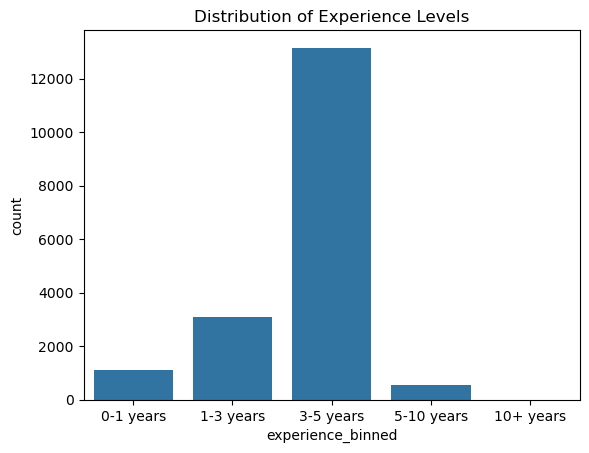

In [104]:
sns.countplot(x='experience_binned', data=posting_df_encoded)
plt.title('Distribution of Experience Levels')
plt.show()

The countplot displays the distribution of job postings across different experience levels (experience_binned).
The majority of the job postings require 3-5 years of experience, followed by 1-3 years

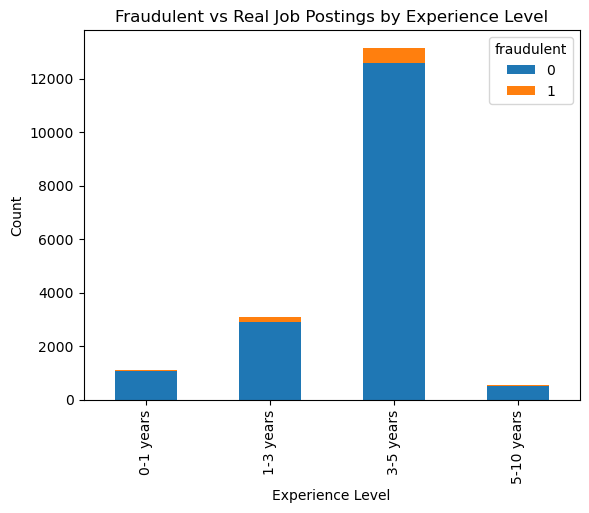

In [106]:
pd.crosstab(posting_df_encoded['experience_binned'], posting_df_encoded['fraudulent']).plot(kind='bar', stacked=True)
plt.title('Fraudulent vs Real Job Postings by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.show()

This stacked bar chart shows the comparison between fraudulent and real job postings across different experience levels.
Most job postings with 3-5 years of experience are real, with only a small fraction being fraudulent.

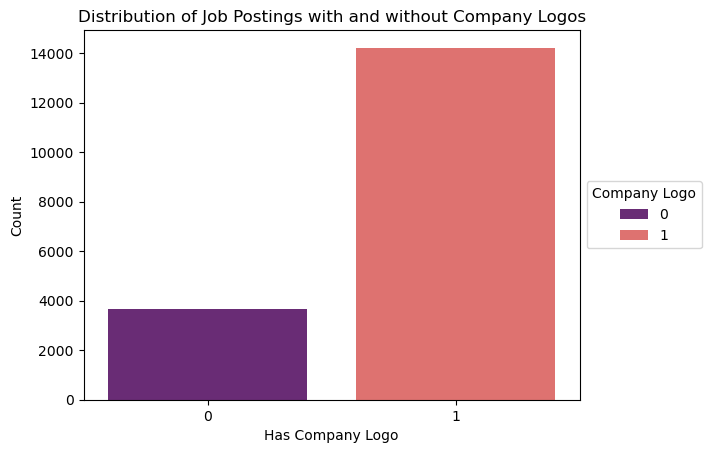

In [108]:
logo_counts = posting_df_encoded['has_company_logo'].value_counts()

sns.barplot(x=logo_counts.index, y=logo_counts.values, hue=logo_counts.index, dodge=False, palette='magma')
plt.xlabel('Has Company Logo')
plt.ylabel('Count')
plt.title('Distribution of Job Postings with and without Company Logos')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Company Logo', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

The bar chart compares the count of job postings that include a company logo (Has Company Logo = 1) versus those that do not (Has Company Logo = 0).
Job postings with company logos are significantly more common than those without.

In [110]:
posting_df_encoded.to_csv('/Users/joycendichu/data_machine_learning/cleaned_postings_dataset.csv', index=False)

**Conclusion**

Feature engineering has greatly improved the quality of the data and made it more useful for analysis and modeling.

Handling Missing Values: Missing data was fixed, making the dataset more complete and reliable. This helps in getting more accurate results.

Encoding Categorical Variables: Text was converted into numbers, allowing machine learning models to use these features effectively.

Reducing Cardinality: Features with too many unique values were simplified. This makes the data easier to work with and improves model performance.

Creating New Features: New features like skills_length and experience_binned were added, providing extra insights. For example, skills_length helps understand the complexity of job titles, and experience_binned shows how different experience levels affect job posting authenticity.

Overall, these changes enhance the dataset’s suitability for analysis and modeling, leading to clearer insights and more accurate predictions.